# Imports and function definitions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

%matplotlib inline

## Aggregate data about arrests

In [2]:
def calculate_arrest_dat(crime_df, year_range=None, sort='rate'):
    """Does the crosstab of crime type and arrest (True/False)
    
    crime_df : the crime dataframe
    year_range (default None) : if not None, the years to consider
    sort (default "rate") : How to sort the data. Either by rate, number,
        or pass an explicit Series
    """
    
    if year_range is not None:
        try:
            a = len(year_range)
        except TypeError:
            year_range = [year_range]
        crime_df = crime_df[(crime_df.index.year >= min(year_range)) 
                            & (crime_df.index.year <= max(year_range))]
    arrests_by_crime = pd.crosstab(crime_df['Primary Type'], crime_df['Arrest'])
    arrests_by_crime['All'] = arrests_by_crime[False] + arrests_by_crime[True]
    try:
        a = sort.upper()
        if sort == 'rate':
            arrest_sort_order = (arrests_by_crime[True] / (arrests_by_crime['All'])).sort_values(ascending=False)
        elif sort == 'number':
            arrest_sort_order = arrests_by_crime['All'].sort_values(ascending=False)
        else:
            raise ValueError('Please pass either rate or number')
    except:
        arrest_sort_order = sort
    arrests_by_crime = arrests_by_crime.loc[arrest_sort_order.index]
    
    return arrests_by_crime

## Plotting functions for arrest data

In [3]:
def plot_arrest_dat_v1(arrest_dat, ax):
    """Plot a vertical bar plot of arrests as a function of crime
    
    Separates each crime into arrest and non-arrest columns
    
    arrest_dat : the pre-aggregated arrest data
    ax : the axis to plot on
    """
    arrest_dat[[0, 1]].plot(kind='bar', ax=ax, color=['C6', 'C2'])
    for i, p in enumerate(ax.patches[len(ax.patches)//2:]):
        ax.text(p.get_x()-0.35, p.get_height()*1.1, 
                f'{arrest_dat[1].values[i] / arrest_dat["All"].values[i] * 100:.1f}%')
    ax.set_yscale('log')
    ax.set_ylim(50, 5e6)
    ax.set_ylabel('Crimes')
    ax.set_xlabel('')
    ax.legend(loc='upper left')

In [4]:
def plot_arrest_dat_v2(arrest_dat, ax, colors=None):
    """Plot a stacked, horizontal bar plot of arrests for different crimes
    
    arrest_dat : the pre-aggregated arrest data
    ax : the axis to plot on"""
    if colors is None:
        colors = [f'C{i}' for i in range(10)]
        colors.insert(4, 'mistyrose')
        colors.append('lavender')

    (arrests_by_crime / arrests_by_crime.sum(axis=0) * 100)[['All', True]].transpose().plot(kind='barh', 
                                          stacked=True, ax=ax, legend=False, color=colors)
    ax.set_yticklabels(['All Reported', 'Arrest Made'], va='center')
    ax.tick_params(axis='y', labelsize=14, rotation=0)
    ax.set_xlabel('Percent of Crimes', fontsize=18)
    ax.set_ylabel('')
    for i, p in enumerate(ax.patches):
        if p.get_width() >= 5:
            if ' ' in arrests_by_crime.index[i%len(ax.patches)//2]:
                to_label = arrests_by_crime.index[i%len(ax.patches)//2].replace(' ', '\n')
            else:
                to_label = arrests_by_crime.index[i%len(ax.patches)//2]
            ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2, to_label,
                   rotation=-90, va='center', ha='center')

# Read in data 

In [5]:
crimedata = pd.read_hdf('/home/elaad/Documents/DatAnalysis/datasets/chicago_crimes.hdf')

First, let's trim down the dataset a little. We want to eliminate the few Primary Types that don't have many examples. Let's say, at least 1000.

In [6]:
incidence = crimedata['Primary Type'].value_counts()
infrequent = incidence[incidence < 1000].index
crimedata = crimedata.replace(to_replace=infrequent, value=np.nan).dropna(axis=0)

# Arrest rates

The following figure shows that about 70% of the reported crimes don't result in an arrest.

Text(0, 0.5, 'Fraction of Crimes')

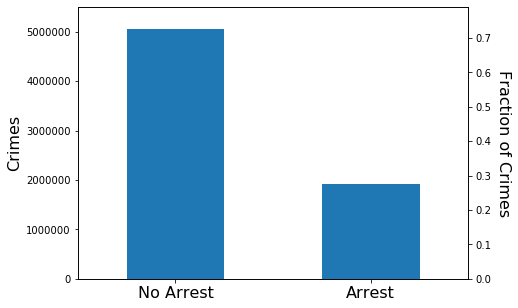

In [7]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5)
arrests = crimedata['Arrest'].value_counts()
arrests.plot(kind='bar', ax=ax)
ax.tick_params(axis='x', labelsize=16, rotation=0)
ax.set_xticklabels(['No Arrest', 'Arrest'])
ax.set_ylabel('Crimes', fontsize=16)
ax2 = ax.twinx()
ax.set_ylim([0, 5.5e6])
ax2.set_ylim([0, 5.5e6 / arrests.sum()])
ax2.set_ylabel('Fraction of Crimes', fontsize=16, rotation=270, labelpad=20)

What's going on here? Where are all the arrests? Well, we can look in more detail in terms of the breakdown of which crimes tend to result in arrests, and which ones don't.

In [8]:
arrests_by_crime = calculate_arrest_dat(crimedata)

The following figure shows the arrest breakdown for all the crimes in the set (recall we dropped the least frequently occurring crimes). These are sorted in decreasing order of arrest rate.

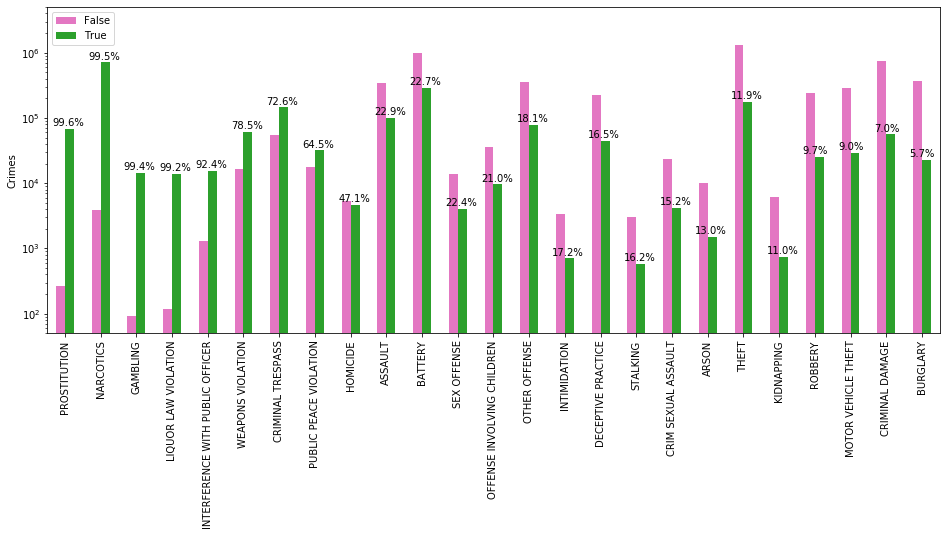

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 6)
plot_arrest_dat_v1(arrests_by_crime, ax)

There are a few interesting things to note in this plot. First, the crimes with by far the highest arrest rates tend to be "victimless" crimes like prostitution and narcotics, with the notable exception of "Interference with public officer". This makes sense: in all likelihood, few people would report these crimes to police. The report must come from police themselves, who would naturally make the arrest.

Interestingly, if dishearteningly, the crimes with the fewest arrests tend to be various types of theft---burglary, robbery, vehicle theft. Most crimes, however, have generally low arrest rates (well below 50%). (NB: Since the y-axis is a log scale, it isn't intuitively obvious what the percentages are, especially on the low end.)

Another way of looking at this is shown in the plot below, where I show the composition (as a percentage) of (1) crimes that result in arrest, and (2) all crimes. The disparity is striking, particularly with regards to narcotics crimes. Despite the overall number of narcotics arrests and reports decreasing dramatically since about 2007 (see chicago-crime.ipynb), people arrested for narcotics crimes continue to be enormously overrepresented. This type of disparity in crimes being committed vs arrests being made can have lasting consequences.

For a year-to-year look, see the figures directory. Most information, however, is contained in plot below.

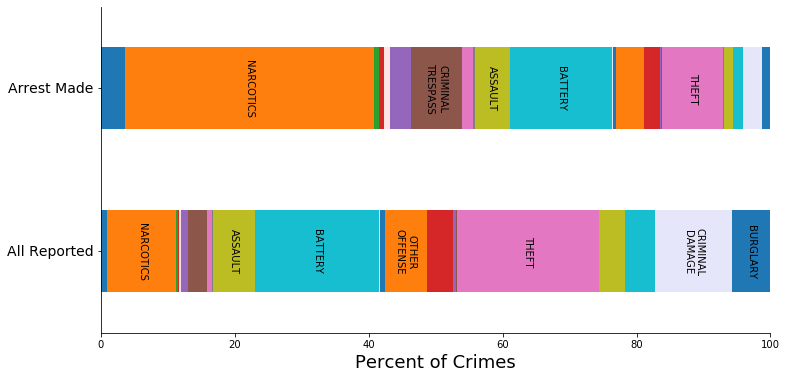

In [10]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 6)
plot_arrest_dat_v2(arrests_by_crime, ax)
ax.set_xlim([0, 100])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [11]:
narcotics_arrests = crimedata[(crimedata['Primary Type'] == 'NARCOTICS') & (crimedata['Arrest'])]
poss_frac = len(narcotics_arrests[narcotics_arrests['Description'].str.startswith('POSS')])
poss_frac /= len(narcotics_arrests)
cann_poss_frac = len(narcotics_arrests[narcotics_arrests['Description']\
                                                    .str.startswith('POSS: CANNABIS 30GMS OR LESS')])
cann_poss_frac /= len(narcotics_arrests)

The disparity is especially disheartening, considering most narcotics arrests are for possession (including marijuana). In fact, the breakdown is worth noting:

In [12]:
md(f'**{poss_frac * 100:.1f}%** of narcotics arrests are for some form of **possession**.  \n' +
   f'**{cann_poss_frac * 100:.1f}%** of narcotics arrests are for **possession of 30g of marijuana or less**.')

**78.2%** of narcotics arrests are for some form of **possession**.  
**38.5%** of narcotics arrests are for **possession of 30g of marijuana or less**.

In [13]:
# sort = calculate_arrest_dat(crimedata) # used to keep the bar stacking order constant

# for year in np.arange(2001, 2020, 1):
#     arrests_by_crime = calculate_arrest_dat(crimedata, year_range=year, sort=sort)
#     fig, ax = plt.subplots(1, 1)
#     fig.set_size_inches(16, 6)
#     plot_arrest_dat_v2(arrests_by_crime, ax)
#     ax.set_title(f'{year}', fontsize=18)
#     fig.savefig(f'../figures/arrest_rates/stacked_bar_plot_{year}.png', dpi=150)